In [1]:
import datetime
import math
import pickle
import string
import time


import numpy as np
import networkx as nx
import pandas as pd
import geopandas as gpd
import shapely.geometry
import matplotlib.pyplot as plt
import momepy
import simpy
import opentnsim.core as core
import pyproj


/Users/baart_f/.virtualenvs/opentnsim/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
name = 'route3a' 
route_gdf = gpd.read_file(f'./experiment3/{name}.geojson')
# do not add d-h
add_d_h_edge = False

In [3]:
geometry_d = route_gdf.set_index('node').loc['D']['geometry']
geometry_h = route_gdf.query("node == 'H'").iloc[0]['geometry']

In [4]:
edges = []

for (_, row_a), (_, row_b) in zip(route_gdf.iloc[:-1].iterrows(), route_gdf.iloc[1:].iterrows()):
    e = row_a['node'], row_b['node']
    edge = {
        'e': e,
        'source': row_a['node'],
        'target': row_b['node'],
        'geometry': shapely.geometry.LineString([row_a['geometry'], row_b['geometry']])
    }
    edges.append(edge)
if add_d_h_edge:
    edge = {
        'e': ('D', 'H'),
        'source': 'D',
        'target': 'H',
        'geometry': shapely.geometry.LineString([geometry_d, geometry_h])
    }
    edges.append(edge)
edges_gdf = gpd.GeoDataFrame(edges)
nodes_gdf = route_gdf.copy()
nodes_gdf['n'] = nodes_gdf.apply(lambda row: row['node'], axis=1)


In [5]:
graph = nx.from_pandas_edgelist(edges_gdf, edge_attr=True)
nodes_gdf.apply(lambda row: graph.nodes[row.n].update(row), axis=1);

for e, edge in graph.edges.items():
    # make all edges 6m deep
    edge['Info'] = {"GeneralDepth": 6}
    
graph.edges[('A', 'B')]

{'e': ('A', 'B'),
 'geometry': <LINESTRING (4.372 52.001, 4.372 52.002)>,
 'Info': {'GeneralDepth': 6}}

<AxesSubplot:>

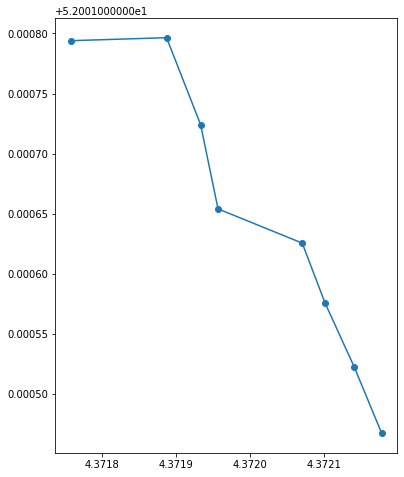

In [6]:
# This is the spatial figure
fig, ax = plt.subplots(figsize=(13, 8))
edges_gdf.plot(ax=ax)
nodes_gdf.plot(ax=ax)

### Network

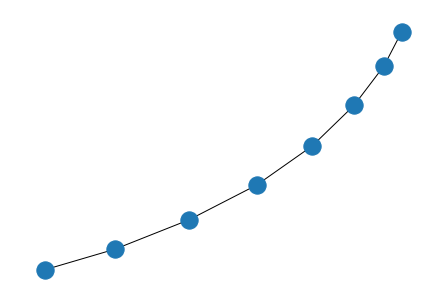

In [7]:
nx.draw(graph)


In [8]:
with open(f"experiment3-{name}-graph.pickle", "wb") as f:
    pickle.dump(graph, f)